# Food UK - Logistic Regression

- _Author_: Lucas Gonzalez Santa Cruz
- _Workshop_: Data Science Intensive, Springboard.com
- _Date_: 2 October 2016

# tl;dr

_In the UK, since 1974, several thousands of families are selected each year (different families each year). Data is collected about **each family** (about 50 variables: place, number of members of different ages, socioeconomic variables), and about **what each family buys over one week** (3 pints of skimmed milk, 2 pounds sterling; etc). Food items ("brown bread") are categorised into food groups ("breads"). For each food item, 47 **nutrients** are known (calories, vitamin D, etc)._

_I'm interested in food generally, but for this project I will only:_
- _define a score of "shopping-cart goodness" (more fruit+vegs than junk food)_
- _look at how some family variables (income, location, etc) predict a "good cart"_

# 1) Motivation and goals

Food is interesting for many inter-related reasons: food security (poverty, climate change and pandemic disruption), nutritional health ("blue zones"), ecological reasons (edible forests), economic developement (jobs), data and automation (mapping images of fields to help agricultural producers).

Here I'll use one particular dataset with the intention of learning to use some machine language procedures. I will look at what types of food are bought by UK families, and attempt to see how their demographic variables "predict" how healthy is their weekly shopping.

# 2) Data source and datasets

UK families (a different sample each year for many years), have been asked what food they buy for a week.

Data between 1974-2000 is open data:
* Available at http://britains-diet.labs.theodi.org
* Datasets:
    * Households: a file with a line per household, and for each of them 53 variables: number of female adults, male adults and children; income; location; etc. Also, many files translating codes to literals: 11=Scotland, 1=household owner is female, etc.
    * Purchases: a file with a line per food item bought: a certain household bought, over the course of a week, 6 loaves of brown bread (money paid), 3 pints of skimmed milk (money paid), etc.
    * Food groups: several files that put the 300+ food items ("milk", "cheese") into 20+ food groups ("milky products").
    * Nutrients: for each food item (and even for 4 "seasons" each year) there's information about 47 nutrients (calories, vitamin D, etc).

(Data since 2001 is published only in summarised form. We won't be using it here.)

# 3) Data wrangling

* We want one line per household.
* Household variables: household identifier, year, and the other 50+ variables.
* Also for each household: how much of each food they bought.

## 3.1) Imports and settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import numpy as np
import scipy as sp

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

## 3.2) Getting the files

In [2]:
#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_2000.zip (etc for all years)
#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_Reference.zip
data = 'data/'
data2000 = 'data/NFSopen_2000/'
dataRefe = 'data/NFSopen_Reference/'

## 3.3) Food codes and groups, and food units

In [3]:
#315 detailed "minor" foodcodes ...
df_min_maj = pd.DataFrame.from_csv(dataRefe+'Ref_ Minor and major foods.txt', sep='\t', index_col=None)
df_min_maj.columns=['minor', 'minor_text', 'major']

#... then aggregated into 184 "major" groups.
df_maj_text = pd.DataFrame.from_csv(dataRefe+'Ref_ Major food codes.txt', sep='\t', index_col=None)
df_maj_text.columns=['major', 'major_text']

#Each "foodcode" (all 315 of them) is described with one of 7 "units": pints, ounces, etc.
df_min_units = pd.DataFrame.from_csv(dataRefe+'Ref_MINFD_Minor_food_codes.txt', sep='\t', index_col=None)
df_min_units.columns=['minor','minor_text','units']
df_min_units.drop(['minor_text'], inplace=True, axis=1) #to avoid duplicate later

#24 more aggregated "groups" were defined, and the 183 previous "detailed groups" were mapped to these 24.
df_grp_text = pd.DataFrame.from_csv(dataRefe+'Ref_ food groups (standard).txt', sep='\t', index_col=None)
df_grp_text.columns=['group','group_text']

#A "mapping" file with 596 rows ...
df_mapping = pd.DataFrame.from_csv(dataRefe+'Ref_ Major-food group mapping.txt', sep='\t', index_col=None)
df_mapping.columns=['major','group']

#... had 92 groups, and those 24 had to be selected.
group24 = [4006, 9017, 22023, 31041, 46094, 100127, 129129, 135148, 150154, 155161, 162171, 172183, \
           184208, 210231, 233248, 251263, 264264, 267277, 281301, 304313, 314339, 340344, 350354, 380389]
df_maj_group = df_mapping[df_mapping['group'].isin(group24) == True] #shape 183x2

# ===== df_groups 315 groups x 6 fields: minor, minor_text, major, major_text, group, group_text
df = pd.merge(df_min_maj, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')
df_groups = df

print len(df), "food items, each with", len(df.columns)," variables:", list(df.columns.values)

print "\nThe 24 food-groups each have a different number of food-items:"
df.groupby('group_text').minor.nunique()

315 food items, each with 6  variables: ['minor', 'minor_text', 'major', 'major_text', 'group', 'group_text']

The 24 food-groups each have a different number of food-items:


group_text
ALCOHOLIC DRINKS                            10
ALL BREAD                                   22
ALL CARCASE MEAT                            17
ALL FATS                                    17
ALL FISH                                    19
ALL NON-CARCASE MEAT AND MEAT PRODUCTS      50
ALL OTHER FOODS                             23
ALL PROCESSED VEGETABLES                    22
BEVERAGES                                    6
BISCUITS, CAKES, BUNS, CRISPBREADS           7
CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS    33
CONFECTIONERY                                6
EGGS                                         1
FLOUR                                        1
FRESH FRUIT                                 10
FRESH GREEN VEGETABLES                       7
FRUIT & FRUIT PRODS. NOT FRESH               6
LIQUID WHOLEMILK, INC SCHOOL & WELFARE       6
OTHER FRESH VEGETABLES                       8
OTHER MILK & CREAM                          14
POTATOES                                    12
SO

## 3.4) Diary entries: what families bought

In [4]:
df_purc1995 = pd.DataFrame.from_csv(data+'1995 diary data.txt', sep='\t', index_col=None)
df_purc1995['survyear'] = '1995'
df_purc1996 = pd.DataFrame.from_csv(data+'1996 diary data.txt', sep='\t', index_col=None)
df_purc1996['survyear'] = '1996'
df_purc1997 = pd.DataFrame.from_csv(data+'1997 diary data.txt', sep='\t', index_col=None)
df_purc1997['survyear'] = '1997'
df_purc1998 = pd.DataFrame.from_csv(data+'1998 diary data.txt', sep='\t', index_col=None)
df_purc1998['survyear'] = '1998'
df_purc1999 = pd.DataFrame.from_csv(data+'1999 diary data.txt', sep='\t', index_col=None)
df_purc1999['survyear'] = '1999'
df_purc2000 = pd.DataFrame.from_csv(data+'2000 diary data.txt', sep='\t', index_col=None)
df_purc2000['survyear'] = '2000'
list_of_years = [df_purc1995, df_purc1996, df_purc1997, df_purc1998, df_purc1999, df_purc2000]
df = pd.concat(list_of_years)
df.columns=['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear']
df_diary8 = df

# ===== idem + adding "_text", "group" and "unit" variables
df = pd.merge(df_diary8, df_min_maj, how='left', on='minor')
df = pd.merge(df, df_min_units, how='left', on='minor')
df = pd.merge(df, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')

# ===== DIARY WITH 14, 10 or 6 VARIABLES
df_diary14 = df
df_diary10 = df[['survyear', 'hhno', 'quantity', 'units', 'minor_text', \
                 'group_text', 'minor', 'major', 'major_text', 'group']]
df_diary6  = df[['survyear', 'hhno', 'minor_text', 'quantity', 'units', 'group_text']]

df = df_diary14
print "DIARY ENTRIES: in 1995-2000, {0:4} families bought {1:6} items, {2:3} foods in {3:2} groups.".\
    format(len(df.hhno.unique()), len(df), len(df.minor_text.unique()), len(df.group_text.unique()))
print len(df.columns), "variables:", list(df.columns.values)

DIARY ENTRIES: in 1995-2000, 42960 families bought 1581381 items, 243 foods in 24 groups.
14 variables: ['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear', 'minor_text', 'major', 'units', 'major_text', 'group', 'group_text']


## 3.5) Households (aka "families")

In [5]:
df_hous1995 = pd.DataFrame.from_csv(data+'1995 household data.txt', sep='\t', index_col=None)
df_hous1995['survyear'] = '1995'
df_hous1996 = pd.DataFrame.from_csv(data+'1996 household data.txt', sep='\t', index_col=None)
df_hous1996['survyear'] = '1996'
df_hous1997 = pd.DataFrame.from_csv(data+'1997 household data.txt', sep='\t', index_col=None)
df_hous1997['survyear'] = '1997'
df_hous1998 = pd.DataFrame.from_csv(data+'1998 household data.txt', sep='\t', index_col=None)
df_hous1998['survyear'] = '1998'
df_hous1999 = pd.DataFrame.from_csv(data+'1999 household data.txt', sep='\t', index_col=None)
df_hous1999['survyear'] = '1999'
df_hous2000 = pd.DataFrame.from_csv(data+'2000 household data.txt', sep='\t', index_col=None)
df_hous2000['survyear'] = '2000'

list_of_years = [df_hous1995, df_hous1996, df_hous1997, df_hous1998, df_hous1999, df_hous2000]
df = pd.concat(list_of_years)
print "Number of households:", len(df) #len(df.columns), list(df.columns.values) #minor inconsistency with 42960 above
df_households = df

Number of households: 43624


### Variables that describe each household

In [6]:
# ===== 53 VARIABLES FOR EACH HOUSEHOLD (+ survyear):
df_house_vars = pd.DataFrame.from_csv(dataRefe+'house-fields.txt', sep='\t', index_col=None)
df_house_vars.columns=['table', 'field', 'field_text', 'type1', 'size', 'type2', 'lookup', 'notes']
df_house_vars = df_house_vars[['field', 'field_text', 'lookup', 'notes']]
df_house_vars

,field,field_text,lookup,notes
0,hhno,household number,NaN,NaN
1,gormet2,government office region metropolitan county,DCV: GORMET2.txt,Not populated before 1997
2,reg,standard statistical region,DCV: Region.txt,NaN
3,lad,local authority district,DCV: LAD.txt,Northern Ireland from 1996 to 2000
4,styr,statistical year,NaN,NaN
5,stmth,statistical month,NaN,NaN
6,mic,ownership of microwave (1 = yes 0= not),DCV: Microwave ownership.txt,Not used before 1989
7,frez,ownership of freezer (1 = yes 0= not),DCV: Freezer ownership.txt,NaN
8,owndw,tenure (ownership of dwelling),DCV: Ownership of dwelling.txt,Coding changed from 1997 on to include squatting
9,memhh,number of members of the household,NaN,This field has been top-coded to remove all ho...


### Selection of household variables

Many variables are difficult to understand unless you're an expert, and I'm not.

In [7]:
#house_vars_list = df_house_vars['field'].unique() #all the variables
df = df_house_vars[['field', 'field_text']]
print "WHERE:\n", df[df.field.isin(['reg'])]
print "\nMEMBERS BY AGE:\n", df[df.field.isin(['memhh', 'adltm', 'child', 'oaps', 'adltgt64', 'earners'])]
print "\nAGEGROUPS:\n", df[df.field.isin(['agehoh_banded', 'agehw_banded', 'agemdk_banded'])]
print "\nVEGETARIAN:\n", df[df.field.isin(['vegind'])]
print "\nMONEY:\n", df[df.field.isin(['incgp', 'occhoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp'])]
print "\nPOSESSIONS:\n", df[df.field.isin(['mic', 'frez', 'frij', 'owndw'])]

WHERE:
  field                   field_text
2   reg  standard statistical region

MEMBERS BY AGE:
       field                                         field_text
9      memhh                 number of members of the household
21     adltm  number of male adults (18 years or over plus 1...
23     child                                 number of children
24      oaps                       number of old age pensioners
25  adltgt64  number of members of the household aged over 6...
37   earners                 number of earners in the household

AGEGROUPS:
            field                         field_text
19  agehoh_banded  age of head of household (banded)
20   agehw_banded          age of housewife (banded)
29  agemdk_banded           age of main diary keeper

VEGETARIAN:
     field            field_text
44  vegind  vegetarian indicator

MONEY:
                           field                                         field_text
11                         incgp          income group of t

### Exploratory data analysis of Households, in order to further select reasonable variables

In [8]:
df = df_households

#=== standard statistical region = 11 x (code, text); Scotland = 1
df_reg = pd.DataFrame.from_csv(dataRefe+'DCV_ Region.txt', sep='\t', index_col=None)
df_reg.columns=['reg', 'reg_text']
df2 = pd.merge(df, df_reg, how='left', on='reg')
print df2.reg_text.value_counts().sort_index()

#=== income group of the head of the household = 8 categories --- I DON'T KNOW WHAT THEY MEAN
df_incgp = pd.DataFrame.from_csv(dataRefe+'DCV_ Income Group.txt', sep='\t', index_col=None)
df_incgp.columns=['incgp', 'income_group']
df2 = pd.merge(df, df_incgp, how='left', on='incgp')
print df2.income_group.value_counts().sort_index()

#=== degree of activity of cross over head of household #sedentary etc --- THEY ARE ALL "OTHER"
df_dactxhoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Degree of activity.txt', sep='\t', index_col=None)
df_dactxhoh.columns=['dactxhoh', 'degree_of_activity']
df2 = pd.merge(df, df_dactxhoh, how='left', on='dactxhoh')
print df2.degree_of_activity.value_counts().sort_index()

print "\nVegetarians? We don't know:\n", df.vegind.value_counts().sort_index()
print "\nIncome:\n", df.Finc_decile_by_members_of_hh.value_counts().sort_index()
print "\nFamily members:\n", df.memhh.value_counts().sort_index()

print "\nChildren:\n", df.child.value_counts().sort_index()
df2 = df
df2['propchild'] = df2.child / df2.memhh
#df2.propchild.hist()

print "\nElderly:\n", df.adltgt64.value_counts().sort_index()
df2 = df
df2['propelderly'] = df2.adltgt64 / df2.memhh
#df2.propelderly.hist() #most old people live without young people

print "\nEarners:\n", df.earners.value_counts().sort_index()
df2 = df
df2['propearners'] = df2.earners / df2.memhh
#df2.propearners.hist()

print "\nBenefits:\n", df.benefits.value_counts().sort_index()

#=== job status of head of household
df_jobsthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Job status of HOH.txt', sep='\t', index_col=None)
df_jobsthoh.columns = ['jobsthoh', 'job_status_hoh']
df2 = pd.merge(df, df_jobsthoh, how='left', on='jobsthoh')
print "\nJob status of hoh:\n", df2.job_status_hoh.value_counts().sort_index()

#===size of work establishment of head of household #sme etc
df_szwkest = pd.DataFrame.from_csv(dataRefe+'DCV_ Size of work establishment.txt', sep='\t', index_col=None)
df_szwkest.columns=['szwkest', 'workplace']
df2 = pd.merge(df, df_szwkest, how='left', on='szwkest')
print "\nSize of workplace of hoh:\n", df2.workplace.value_counts().sort_index()

#=== tenure (ownership of dwelling) = 7 categories
df_owndw = pd.DataFrame.from_csv(dataRefe+'DCV_ Ownership of dwelling.txt', sep='\t', index_col=None)
df_owndw.columns=['owndw', 'ownhome']
df2 = pd.merge(df, df_owndw, how='left', on='owndw')
print "\nOwnership of dwelling:\n", df2.ownhome.value_counts().sort_index()

EAST ANGLIA            1664
EAST MIDLANDS          2984
NORTH WEST             4602
NORTHERN               2453
NORTHERN IRELAND       3459
SCOTLAND               3682
SOUTH EAST            11670
SOUTH WEST             3546
WALES                  2359
WEST MIDLANDS          3667
YORKS & HUMBERSIDE     3538
Name: reg_text, dtype: int64
A1       991
A2      1909
B      10922
C      11885
D       2835
E1      4125
E2      5707
OAP     5250
Name: income_group, dtype: int64
OTHER    30065
Name: degree_of_activity, dtype: int64

Vegetarians? We don't know:
0.0    27347
1.0      630
2.0     2088
Name: vegind, dtype: int64

Income:
0     3939
1     3948
2     3982
3     3961
4     3967
5     3971
6     3967
7     3978
8     3973
9     3969
10    3969
Name: Finc_decile_by_members_of_hh, dtype: int64

Family members:
1     10797
2     15250
3      7295
4      6706
5      2508
6       743
7       230
8        58
9        27
10       10
Name: memhh, dtype: int64

Children:
0    28733
1     5982
2 

### Selected variables, included in the file as literals

In [9]:
#df_house_vars[df_house_vars.field.isin(selected_vars)]

In [10]:
df = df_households

#=== standard statistical region
df_reg = pd.DataFrame.from_csv(dataRefe+'DCV_ Region.txt', sep='\t', index_col=None)
df_reg.columns=['reg', 'reg_text']
df = pd.merge(df, df_reg, how='left', on='reg')

#=== income group of the head of the household
df_incgp = pd.DataFrame.from_csv(dataRefe+'DCV_ Income Group.txt', sep='\t', index_col=None)
df_incgp.columns=['incgp', 'income_group']
df = pd.merge(df, df_incgp, how='left', on='incgp')

#=== job status of head of household
df_jobsthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Job status of HOH.txt', sep='\t', index_col=None)
df_jobsthoh.columns = ['jobsthoh', 'job_status_hoh']
df = pd.merge(df, df_jobsthoh, how='left', on='jobsthoh')

#===size of work establishment of head of household
df_szwkest = pd.DataFrame.from_csv(dataRefe+'DCV_ Size of work establishment.txt', sep='\t', index_col=None)
df_szwkest.columns=['szwkest', 'workplace']
df = pd.merge(df, df_szwkest, how='left', on='szwkest')

#=== tenure (ownership of dwelling) = 7 categories
df_owndw = pd.DataFrame.from_csv(dataRefe+'DCV_ Ownership of dwelling.txt', sep='\t', index_col=None)
df_owndw.columns=['owndw', 'ownhome']
df = pd.merge(df, df_owndw, how='left', on='owndw')

df.drop(['gormet2', 'lad', 'styr', 'stmth', \
         'schmilk', 'occhoh', 'sochoh', 'finctp', 'pernohoh', 'pernohw', 'stqtr', 'gor', 'incgpa', \
         'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'occxhoh', 'socxhoh',\
         'wkdy1rec', 'gornw', 'pernxhoh', 'incgp745', \
         'propchild', 'propelderly', 'propearners', \
         'reg', 'incgp', 'jobsthoh', 'szwkest', 'owndw'], inplace=True, axis=1)
df_households = df
df.head()

,hhno,mic,frez,memhh,dacthoh,Finc_decile_by_members_of_hh,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,country,agemdk_banded,frij,earners,dactxhoh,empst,vegind,withjob,landlord,furnish,benefits,survyear,reg_text,income_group,job_status_hoh,workplace,ownhome
0,224203,1,1,3,NaN,10,4.0,4.0,1,1,1,0,0,Wales,4.0,0.0,1,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,A1,SELF EMPLOYED WITH EMPLOYEES,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS WITH MORTGAGE
1,224204,1,1,1,NaN,0,3.0,3.0,1,0,0,0,0,Wales,3.0,0.0,1,0.0,2,2.0,NaN,NaN,NaN,0,1995,WALES,B,FOREMEN/SUPERVISORS,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT
2,224205,0,0,2,NaN,0,4.0,4.0,1,1,0,0,0,Wales,4.0,0.0,2,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,C,APPRENTICES/EMPLOYEES NEC,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT
3,224206,1,1,2,NaN,0,5.0,5.0,1,1,0,0,0,Wales,5.0,0.0,2,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,B,MANAGERS,WORKS FOR ESTABLISHMENT OF 25 OR MORE,OWNS OUTRIGHT
4,224207,1,0,1,NaN,1,7.0,7.0,0,1,0,1,1,Wales,7.0,0.0,0,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,OAP,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,UNFURNISHED COUNCIL


## 3.6) Summary variables: what each family buys in terms of foods and foodgroups

In [11]:
# ===== FOODS PER HOUSEHOLD =====
df = df_diary14
df_household_foods = pd.crosstab(df.hhno, df.minor_text, values = df.quantity, aggfunc=np.sum)
df_household_foods = df_household_foods.fillna(0)
df_household_foods.reset_index(level=0, inplace=True)
df = df_household_foods
#print "FOODS PER HOUSEHOLD: shape, number of variables, and variables:", \
#df.shape, len(df.columns), list(df.columns.values)

In [12]:
# ===== FOOD-GROUPS PER HOUSEHOLD =====
df = df_diary14[['hhno', 'quantity', 'group_text']]
df_household_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_groups = df_household_groups.fillna(0)
df_household_groups.reset_index(level=0, inplace=True)
df = df_household_groups
#print "FOOD GROUP PER HOUSEHOLD: shape, number of variables, and variables:",\
#df.shape, len(df.columns), list(df.columns.values)

In [13]:
# ===== HOUSEHOLDS WITH THEIR FOOD-GROUPS =====
df = pd.merge(df_households, df_household_groups, how='left', on='hhno')
df_hh_with_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 50 (now less) demographic variables + 24 food-group variables."
#print "\nShape:", df.shape
#print "Number of variables:", len(df.columns)
#print "Variables:", list(df.columns.values)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 50 (now less) demographic variables + 24 food-group variables.


# 4) Logistic regression

## 4.1) Compute score and classification variable

For each household:
- a score of "good food", say dividing the amount of fruit per the amount of chocolate (or the other way round, depending who you ask!)
- and then a categorisation of that score, say stating that a score higher than 5 is good

### a) Decide which foods are good or bad

I'm not a nutrition expert, but here's a rough idea of how I'd approach this:

- Low nutritional value: 'ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES'
- Some doubts: 'ALL BREAD' ("WHITE"?), 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS'
- Generally good food: the rest

In [14]:
all_groups = df_grp_text.group_text.tolist()
#all_groups = df_groups.group_text.unique()

bad_groups = ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', \
             'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', \
             'SUGAR AND PRESERVES']

good_groups = [x for x in all_groups if x not in bad_groups and x is not np.nan]
print "good groups:", good_groups
print "\nbad groups:", bad_groups

df = df_diary14[['hhno', 'quantity', 'group_text']]
df_good = df[df.group_text.isin(good_groups)]
df_bad = df[df.group_text.isin(bad_groups)]
#print "All food purchases split in good and bad:", len(df), len(df_good), len(df_bad)

good groups: ['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL FISH', 'EGGS', 'ALL FATS', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS']

bad groups: ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES']


### b) Trying "quantities of food"

In [15]:
# ===== SUM_GOOD = quantity of all good food groups, for each household

df = df_good
df_household_good_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
#print "GOOD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

In [16]:
# ===== SUM_BAD = idem for "not good" groups

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1) + 0.1 #in 24 cases it's zero, so maybe turn it into 0.1
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
#print "BAD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

(516188, 3)


**NOTE TO SELF: It would be much cleaner to merge the hh variables only when they are needed; i.e., later. But it's not a priority right now.**

In [17]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(1)
df['how_good'] = df['sum_good'] / (df['sum_bad'] + df['sum_good'])
df['how_bad'] = df['sum_bad'] / (df['sum_bad'] + df['sum_good'])
df_hh_with_all_food_groups = df
#print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
#print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
#print "+ variables describing the goodness/badness of their shopping cart."
#print "Here's a sample:"
#df.head(3)

In [18]:
# Numerical comparison of the created variables

print df[['sum_good', 'sum_bad', 'how_good', 'how_bad']].describe()
print "SUM GOOD:",  len(df[df.sum_good == 0]), "are zero. ", len(df[df.sum_good == np.nan]), "are NaN."
print "SUM BAD:",   len(df[df.sum_bad == 0]),  "are zero. ", len(df[df.sum_bad == np.nan]),  "are NaN."
print "HOW GOOD: ", len(df[df.how_good == 0]), "are zero. ", len(df[df.how_good == np.nan]), "are NaN."
print "HOW BAD",    len(df[df.how_bad == 0]), " are zero. ", len(df[df.how_bad == np.nan]),  "are NaN."

           sum_good       sum_bad      how_good       how_bad
count  43624.000000  43624.000000  43624.000000  43624.000000
mean     457.767722    460.089837      0.569734      0.430266
std      359.387733    553.028197      0.217196      0.217196
min        0.220000      0.100000      0.001169      0.000099
25%      209.847500    107.450000      0.412579      0.264503
50%      396.275000    289.045000      0.569041      0.430959
75%      624.402500    621.312500      0.735497      0.587421
max    13930.670000  12785.340000      0.999901      0.998831
SUM GOOD: 0 are zero.  0 are NaN.
SUM BAD: 0 are zero.  0 are NaN.
HOW GOOD:  0 are zero.  0 are NaN.
HOW BAD 0  are zero.  0 are NaN.


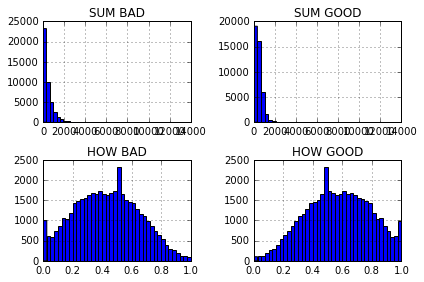

In [19]:
# Graphical comparison of the created variables
fig, axes = plt.subplots(nrows=2, ncols=2)
df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')
plt.tight_layout()

### c) Trying "number of times each food is bought"

In [20]:
# ===== ADD UP ALL TIMES EACH FOOD IS BOUGHT (EXCEPT HHNO) INTO SUM_GOOD

df = df_good
df_household_good_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
#print "GOOD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

In [21]:
# ===== ADD UP ALL TIMES EACH FOOD IS BOUGHT (EXCEPT HHNO) INTO SUM_BAD

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1) # + 0.1 #in 24 cases it's zero, so maybe turn it into 0.1
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
#print "BAD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

(516188, 3)


In [22]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(0.1)
df['how_good'] = df['sum_good'] / (df['sum_good'] + df['sum_bad'])
df['how_bad'] = df['sum_bad'] / (df['sum_good'] +  df['sum_bad'])
df_hh_with_all_food_groups = df
#print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
#print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
#print "+ variables describing the goodness/badness of their shopping cart."
#print "Here's a sample:"
#df.head(3)

In [23]:
# Numerical comparison of the created variables

print df[['sum_good', 'sum_bad', 'how_good', 'how_bad']].describe()
print "SUM GOOD:",  len(df[df.sum_good == 0]), "are zero. ", len(df[df.sum_good == np.nan]), "are NaN."
print "SUM BAD:",   len(df[df.sum_bad == 0]),  "are zero. ", len(df[df.sum_bad == np.nan]),  "are NaN."
print "HOW GOOD: ", len(df[df.how_good == 0]), "are zero. ", len(df[df.how_good == np.nan]), "are NaN."
print "HOW BAD",    len(df[df.how_bad == 0]), " are zero. ", len(df[df.how_bad == np.nan]),  "are NaN."

           sum_good       sum_bad      how_good       how_bad
count  43624.000000  43624.000000  43624.000000  43624.000000
mean      24.419299     11.837782      0.685303      0.314697
std       14.102010      8.717686      0.132256      0.132256
min        0.100000      0.100000      0.012346      0.001883
25%       14.000000      5.000000      0.600000      0.232107
50%       23.000000     10.000000      0.683333      0.316667
75%       33.000000     17.000000      0.767893      0.400000
max      115.000000     92.000000      0.998117      0.987654
SUM GOOD: 0 are zero.  0 are NaN.
SUM BAD: 0 are zero.  0 are NaN.
HOW GOOD:  0 are zero.  0 are NaN.
HOW BAD 0  are zero.  0 are NaN.


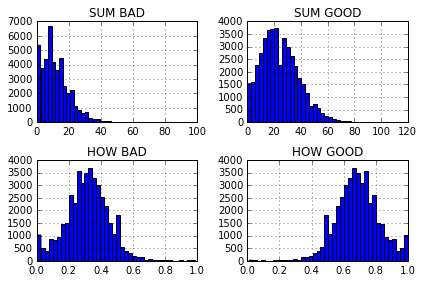

In [24]:
# Graphical comparison of the created variables
fig, axes = plt.subplots(nrows=2, ncols=2)
df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')
plt.tight_layout()

### d) Creating categories ("good cart")

In [25]:
df = df_hh_with_all_food_groups
#df['good_cart'] = df.sum_good > 23 #median
df['good_cart'] = df.how_good > 0.683333  # > 0.767893 #=75% (0.683333 = 50% = median)
df.good_cart = df.good_cart.astype(int)
df_cat = df
print df_cat.good_cart.value_counts()
#df_cat[['hhno', 'sum_good', 'sum_bad', 'how_good', 'how_bad', 'good_cart']].head()

1    21828
0    21796
Name: good_cart, dtype: int64


## 4.2) Look at which "explanatory variables" might be promissing

In [26]:
print "MEANS OF ALL HOUSEHOLD VARIABLES BY GOOD_CART:"
df_cat.groupby('good_cart').mean().transpose().head(23)

MEANS OF ALL HOUSEHOLD VARIABLES BY GOOD_CART:


good_cart,0,1
hhno,245957.098091,245953.868426
mic,0.803863,0.760262
frez,0.919756,0.914513
memhh,2.644109,2.372641
dacthoh,0.100000,0.100000
Finc_decile_by_members_of_hh,5.112360,4.898846
agehoh_banded,3.898229,4.258846
agehw_banded,3.732098,4.108448
adltm,0.927234,0.845428
adltf,0.982979,0.990975


In [27]:
df_cat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hhno,43624.0,245955.482074,1.289457e+04,100136.000000,235093.750000,246000.500000,256907.250000,267819.000000
mic,43624.0,0.782047,4.128603e-01,0.000000,1.000000,1.000000,1.000000,1.000000
frez,43624.0,0.917133,2.756846e-01,0.000000,1.000000,1.000000,1.000000,1.000000
memhh,43624.0,2.508275,1.336382e+00,1.000000,2.000000,2.000000,3.000000,10.000000
dacthoh,43624.0,0.100000,2.775589e-17,0.100000,0.100000,0.100000,0.100000,0.100000
Finc_decile_by_members_of_hh,43624.0,5.005524,3.160195e+00,0.000000,2.000000,5.000000,8.000000,10.000000
agehoh_banded,43624.0,4.078670,1.702887e+00,0.100000,3.000000,4.000000,5.000000,7.000000
agehw_banded,43624.0,3.920411,1.713561e+00,0.100000,2.000000,4.000000,5.000000,7.000000
adltm,43624.0,0.886301,5.838463e-01,0.000000,1.000000,1.000000,1.000000,5.000000
adltf,43624.0,0.986980,4.853634e-01,0.000000,1.000000,1.000000,1.000000,7.000000


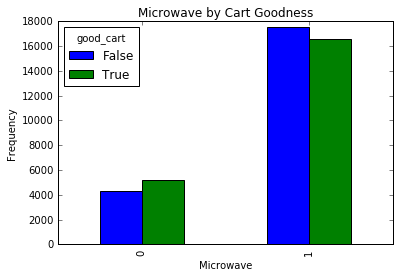

In [28]:
#Having a microwave seems to be associated with diet
pd.crosstab(df_cat.mic, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Microwave by Cart Goodness')
plt.xlabel('Microwave')
plt.ylabel('Frequency')

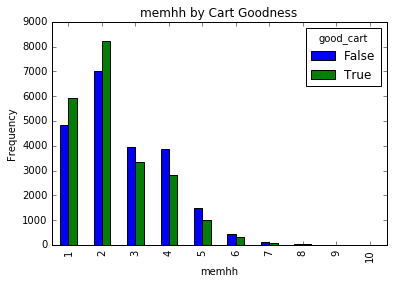

In [29]:
#Larger memhh seems to be associated with diet
pd.crosstab(df_cat.memhh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('memhh by Cart Goodness')
plt.xlabel('memhh')
plt.ylabel('Frequency')

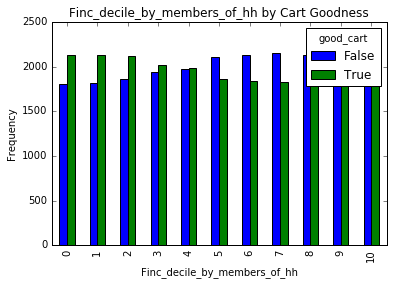

In [30]:
#Finc_decile_by_members_of_hh seems to be associated with diet
pd.crosstab(df_cat.Finc_decile_by_members_of_hh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Finc_decile_by_members_of_hh by Cart Goodness')
plt.xlabel('Finc_decile_by_members_of_hh')
plt.ylabel('Frequency')

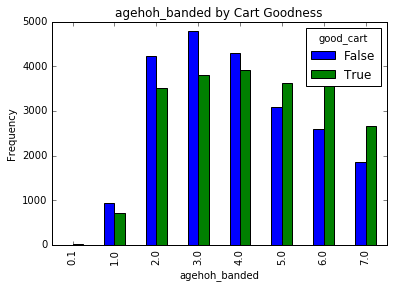

In [31]:
#agehoh_banded seems to be associated with diet
pd.crosstab(df_cat.agehoh_banded, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('agehoh_banded by Cart Goodness')
plt.xlabel('agehoh_banded')
plt.ylabel('Frequency')

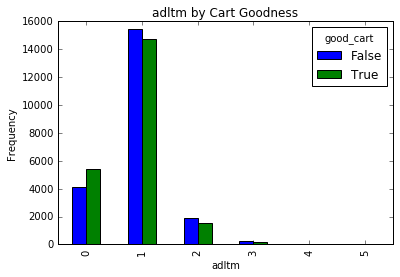

In [32]:
#adltm seems to be associated with diet
pd.crosstab(df_cat.adltm, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('adltm by Cart Goodness')
plt.xlabel('adltm')
plt.ylabel('Frequency')

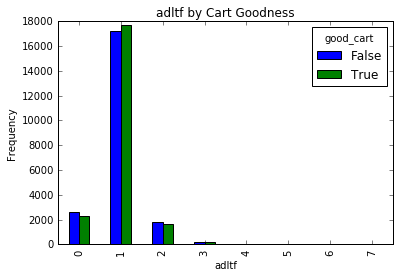

In [33]:
#adltf seems to be associated with diet
pd.crosstab(df_cat.adltf, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('adltf by Cart Goodness')
plt.xlabel('adltf')
plt.ylabel('Frequency')

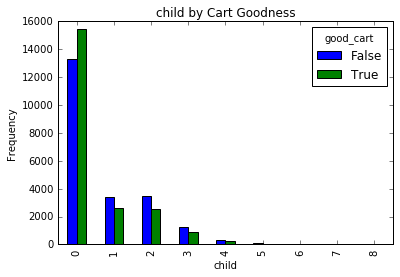

In [34]:
#child seems to be associated with diet
pd.crosstab(df_cat.child, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('child by Cart Goodness')
plt.xlabel('child')
plt.ylabel('Frequency')

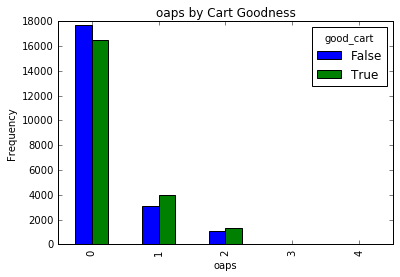

In [35]:
#oaps seems to be associated with diet
pd.crosstab(df_cat.oaps, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('oaps by Cart Goodness')
plt.xlabel('oaps')
plt.ylabel('Frequency')

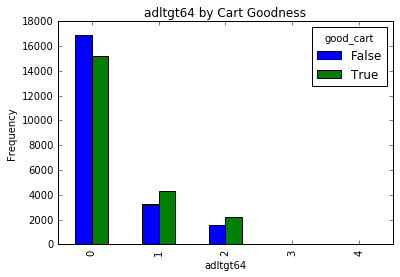

In [36]:
#adltgt64 seems to be associated with diet
pd.crosstab(df_cat.adltgt64, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('adltgt64 by Cart Goodness')
plt.xlabel('adltgt64')
plt.ylabel('Frequency')

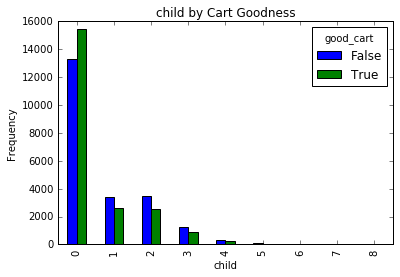

In [37]:
#child seems to be associated with diet
pd.crosstab(df_cat.child, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('child by Cart Goodness')
plt.xlabel('child')
plt.ylabel('Frequency')

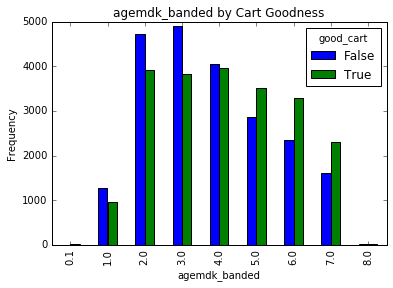

In [38]:
#agemdk_banded seems to be associated with diet
pd.crosstab(df_cat.agemdk_banded, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('agemdk_banded by Cart Goodness')
plt.xlabel('agemdk_banded')
plt.ylabel('Frequency')

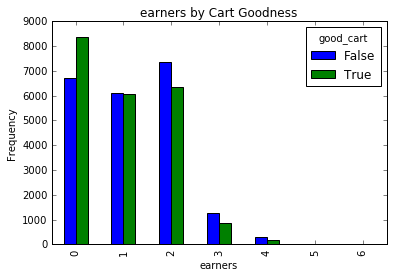

In [39]:
#earners seems to be associated with diet
pd.crosstab(df_cat.earners, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('earners by Cart Goodness')
plt.xlabel('earners')
plt.ylabel('Frequency')

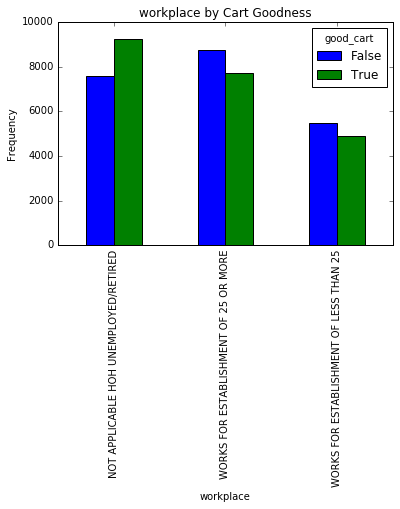

In [40]:
#workplace seems to be associated with diet
pd.crosstab(df_cat.workplace, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('workplace by Cart Goodness')
plt.xlabel('workplace')
plt.ylabel('Frequency')

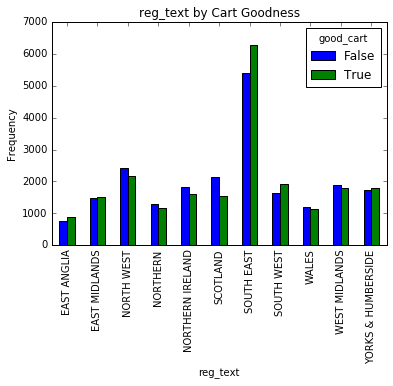

In [41]:
#reg_text seems to be associated with diet
pd.crosstab(df_cat.reg_text, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('reg_text by Cart Goodness')
plt.xlabel('reg_text')
plt.ylabel('Frequency')

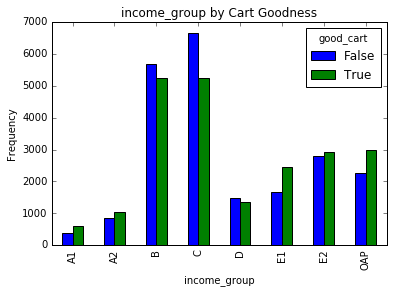

In [42]:
#income_group seems to be associated with diet
pd.crosstab(df_cat.income_group, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('income_group by Cart Goodness')
plt.xlabel('income_group')
plt.ylabel('Frequency')

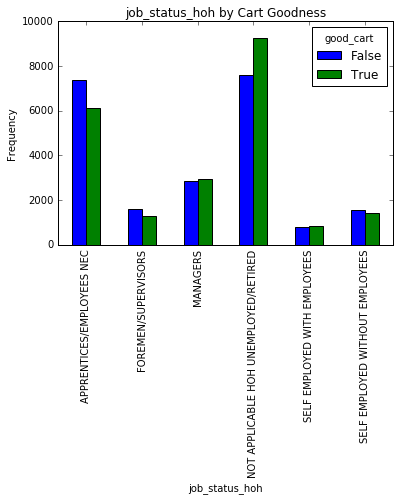

In [43]:
#job_status_hoh seems to be associated with diet
pd.crosstab(df_cat.job_status_hoh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('job_status_hoh by Cart Goodness')
plt.xlabel('job_status_hoh')
plt.ylabel('Frequency')

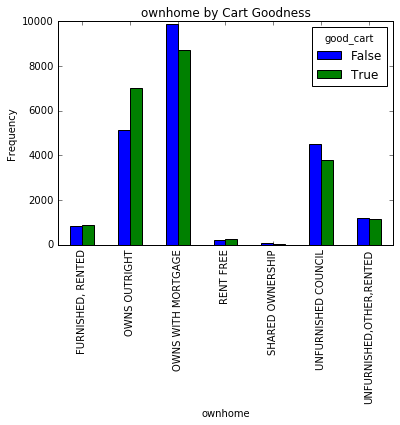

In [44]:
#ownhome seems to be associated with diet
pd.crosstab(df_cat.ownhome, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('ownhome by Cart Goodness')
plt.xlabel('ownhome')
plt.ylabel('Frequency')

## 4.3) Create the matrices that will be used by the model

In [45]:
df_cat.columns

Index([u'hhno', u'mic', u'frez', u'memhh', u'dacthoh', u'Finc_decile_by_members_of_hh', u'agehoh_banded', u'agehw_banded', u'adltm', u'adltf', u'child', u'oaps', u'adltgt64', u'country', u'agemdk_banded', u'frij', u'earners', u'dactxhoh', u'empst', u'vegind', u'withjob', u'landlord', u'furnish', u'benefits', u'survyear', u'reg_text', u'income_group', u'job_status_hoh', u'workplace', u'ownhome', u'ALL BREAD', u'ALL CARCASE MEAT', u'ALL FATS', u'ALL FISH', u'ALL PROCESSED VEGETABLES',
       u'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', u'EGGS', u'FLOUR', u'FRESH FRUIT', u'FRESH GREEN VEGETABLES', u'FRUIT & FRUIT PRODS. NOT FRESH', u'LIQUID WHOLEMILK, INC SCHOOL & WELFARE', u'OTHER FRESH VEGETABLES', u'OTHER MILK & CREAM', u'POTATOES', u'TOTAL CHEESE', u'sum_good', u'ALCOHOLIC DRINKS', u'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', u'ALL OTHER FOODS', u'BEVERAGES', u'BISCUITS, CAKES, BUNS, CRISPBREADS', u'CONFECTIONERY', u'SOFT DRINKS', u'SUGAR AND PRESERVES', u'sum_bad',
       u'how_good', 

In [63]:
df = df_cat
df = df[['hhno', 'mic', 'frez', 'memhh', 'Finc_decile_by_members_of_hh', 'agehoh_banded', \
                 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'country', 'agemdk_banded',\
                 'frij', 'earners', 'vegind', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear',\
                 'reg_text', 'income_group', 'job_status_hoh', 'workplace', 'ownhome', 'good_cart']]
df.columns = ['hhno', 'micro', 'freez', 'people', 'income', 'age_head', 'age_hwife', 'males', 'females',\
                  'children', 'oaps', 'seniors', 'country', 'age_reporter', 'fridge', 'earners', 'veget', \
                  'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'region', 'income_group', \
                  'job_status', 'workplace', 'own_home', 'good_cart']
df = df[['hhno', 'good_cart', \
                 'veget', \
                 'micro', 'freez', 'fridge', 'own_home', 'landlord', 'furnish', \
                 'people', 'males', 'females', 'children', 'oaps', 'seniors', 'earners', \
                 'age_head', 'age_hwife', 'age_reporter', \
                 'income', 'income_group', 'benefits', 'workplace', 'job_status', 'withjob', \
                 'country', 'region', 'survyear']]
df_clean = df
df.head()

,hhno,good_cart,veget,micro,freez,fridge,own_home,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,income_group,benefits,workplace,job_status,withjob,country,region,survyear
0,224203,1,0.0,1,1,0.0,OWNS WITH MORTGAGE,0.1,0.1,3,1,1,1,0,0,1,4.0,4.0,4.0,10,A1,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,SELF EMPLOYED WITH EMPLOYEES,0.1,Wales,WALES,1995
1,224204,0,2.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,1,1,0,0,0,0,1,3.0,3.0,3.0,0,B,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,FOREMEN/SUPERVISORS,0.1,Wales,WALES,1995
2,224205,1,0.0,0,0,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,4.0,4.0,4.0,0,C,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,APPRENTICES/EMPLOYEES NEC,0.1,Wales,WALES,1995
3,224206,1,0.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,5.0,5.0,5.0,0,B,0,WORKS FOR ESTABLISHMENT OF 25 OR MORE,MANAGERS,0.1,Wales,WALES,1995
4,224207,0,0.0,1,0,0.0,UNFURNISHED COUNCIL,0.1,0.1,1,0,1,0,1,1,0,7.0,7.0,7.0,1,OAP,0,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,0.1,Wales,WALES,1995


In [64]:
from patsy import dmatrices

y, X = dmatrices('good_cart ~ veget + micro + freez + fridge + own_home + landlord + furnish + \
                  people + males + females + children + oaps + seniors + earners + \
                  age_head + age_hwife + age_reporter + \
                  income + income_group + benefits + workplace + job_status + withjob + \
                  country + region + survyear', df, return_type="dataframe")

print X.columns
X.head()

Index([u'Intercept', u'own_home[T.OWNS OUTRIGHT]', u'own_home[T.OWNS WITH MORTGAGE]', u'own_home[T.RENT FREE]', u'own_home[T.SHARED OWNERSHIP]', u'own_home[T.UNFURNISHED COUNCIL]', u'own_home[T.UNFURNISHED,OTHER,RENTED]', u'income_group[T.A2]', u'income_group[T.B]', u'income_group[T.C]', u'income_group[T.D]', u'income_group[T.E1]', u'income_group[T.E2]', u'income_group[T.OAP]', u'workplace[T.WORKS FOR ESTABLISHMENT OF 25 OR MORE]', u'workplace[T.WORKS FOR ESTABLISHMENT OF LESS THAN 25]',
       u'job_status[T.FOREMEN/SUPERVISORS]', u'job_status[T.MANAGERS]', u'job_status[T.NOT APPLICABLE HOH UNEMPLOYED/RETIRED]', u'job_status[T.SELF EMPLOYED WITH EMPLOYEES]', u'job_status[T.SELF EMPLOYED WITHOUT EMPLOYEES]', u'country[T.N Ireland]', u'country[T.Scotland]', u'country[T.Wales]', u'region[T.EAST MIDLANDS]', u'region[T.NORTH WEST]', u'region[T.NORTHERN]', u'region[T.NORTHERN IRELAND]', u'region[T.SCOTLAND]', u'region[T.SOUTH EAST]', u'region[T.SOUTH WEST]', u'region[T.WALES]',
       u'reg

,Intercept,own_home[T.OWNS OUTRIGHT],own_home[T.OWNS WITH MORTGAGE],own_home[T.RENT FREE],own_home[T.SHARED OWNERSHIP],own_home[T.UNFURNISHED COUNCIL],"own_home[T.UNFURNISHED,OTHER,RENTED]",income_group[T.A2],income_group[T.B],income_group[T.C],income_group[T.D],income_group[T.E1],income_group[T.E2],income_group[T.OAP],workplace[T.WORKS FOR ESTABLISHMENT OF 25 OR MORE],workplace[T.WORKS FOR ESTABLISHMENT OF LESS THAN 25],job_status[T.FOREMEN/SUPERVISORS],job_status[T.MANAGERS],job_status[T.NOT APPLICABLE HOH UNEMPLOYED/RETIRED],job_status[T.SELF EMPLOYED WITH EMPLOYEES],job_status[T.SELF EMPLOYED WITHOUT EMPLOYEES],country[T.N Ireland],country[T.Scotland],country[T.Wales],region[T.EAST MIDLANDS],region[T.NORTH WEST],region[T.NORTHERN],region[T.NORTHERN IRELAND],region[T.SCOTLAND],region[T.SOUTH EAST],region[T.SOUTH WEST],region[T.WALES],region[T.WEST MIDLANDS],region[T.YORKS & HUMBERSIDE],survyear[T.1996],survyear[T.1997],survyear[T.1998],survyear[T.1999],survyear[T.2000],veget,micro,freez,fridge,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,benefits,withjob
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.1,0.1,3.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,4.0,4.0,10.0,0.0,0.1
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.1,0.1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,0.0,0.1
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,2.0,1.0,1.0,0.0,0.0,0.0,2.0,4.0,4.0,4.0,0.0,0.0,0.1
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.1,0.1,2.0,1.0,1.0,0.0,0.0,0.0,2.0,5.0,5.0,5.0,0.0,0.0,0.1
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.1,0.1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,7.0,7.0,7.0,1.0,0.0,0.1


In [65]:
y.head()

,good_cart
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


In [66]:
# flatten y into a 1-D array
y = np.ravel(y)
print y

[ 1.  0.  1. ...,  1.  1.  1.]


## 4.4) Instantiate a LR model and look at it

In [67]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
model = model.fit(X, y)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
# check the accuracy (on the training set ?)
model.score(X, y) #0.57633412800293415 with HOW_GOOD = median
#0.75958188153310102  with HOW_GOOD = percentile 75.

0.58791032459196768

**^ QUESTION: What does this mean?  It looks as if the model is only slightly better than predicting at random?**

In [70]:
y.mean()

0.50036677058499912

In [71]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.182404944244]
1,own_home[T.OWNS OUTRIGHT],[0.170203577427]
2,own_home[T.OWNS WITH MORTGAGE],[0.0407856894566]
3,own_home[T.RENT FREE],[0.266051314532]
4,own_home[T.SHARED OWNERSHIP],[0.0154927547754]
5,own_home[T.UNFURNISHED COUNCIL],[-0.133478407234]
6,"own_home[T.UNFURNISHED,OTHER,RENTED]",[-0.0251331115864]
7,income_group[T.A2],[-0.191082134529]
8,income_group[T.B],[-0.406875024799]
9,income_group[T.C],[-0.564098876506]


In [72]:
df_coef = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
df_coef.sort_values(1)

,0,1
13,income_group[T.OAP],[-0.62511379448]
12,income_group[T.E2],[-0.620779158886]
9,income_group[T.C],[-0.564098876506]
11,income_group[T.E1],[-0.522477516312]
10,income_group[T.D],[-0.51170767156]
8,income_group[T.B],[-0.406875024799]
25,region[T.NORTH WEST],[-0.218531690972]
22,country[T.Scotland],[-0.215919035393]
28,region[T.SCOTLAND],[-0.215919035393]
26,region[T.NORTHERN],[-0.206292400665]


**^ QUESTION: Does the (absolute) size of the coefficient matter for variable selection?**

If "YES", then I'd select income_group, region, veget, own_home

In [73]:
print "MEANS of all variables (first 52, then 28), by GOOD_CART:"
df.groupby('good_cart').mean().transpose().head(52)

MEANS of all variables (first 52, then 28), by GOOD_CART:


good_cart,0,1
hhno,245957.098091,245953.868426
veget,0.094531,0.187901
micro,0.803863,0.760262
freez,0.919756,0.914513
fridge,0.031033,0.031130
landlord,0.404822,0.406061
furnish,0.429138,0.390851
people,2.644109,2.372641
males,0.927234,0.845428
females,0.982979,0.990975


In [74]:
#print "(second half of the list)"
#df.groupby('good_cart').mean().transpose().tail(28)
#not displayed because they are the Food-Groups, so they are already part of the "good_cart" variable.

**^ QUESTION: I don't know how to select which variables are more interesting**
_df.groupby('memhh').mean()_

## 4.5) Cross-validation

In [76]:
df = df_clean
df.head()

,hhno,good_cart,veget,micro,freez,fridge,own_home,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,income_group,benefits,workplace,job_status,withjob,country,region,survyear
0,224203,1,0.0,1,1,0.0,OWNS WITH MORTGAGE,0.1,0.1,3,1,1,1,0,0,1,4.0,4.0,4.0,10,A1,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,SELF EMPLOYED WITH EMPLOYEES,0.1,Wales,WALES,1995
1,224204,0,2.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,1,1,0,0,0,0,1,3.0,3.0,3.0,0,B,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,FOREMEN/SUPERVISORS,0.1,Wales,WALES,1995
2,224205,1,0.0,0,0,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,4.0,4.0,4.0,0,C,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,APPRENTICES/EMPLOYEES NEC,0.1,Wales,WALES,1995
3,224206,1,0.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,5.0,5.0,5.0,0,B,0,WORKS FOR ESTABLISHMENT OF 25 OR MORE,MANAGERS,0.1,Wales,WALES,1995
4,224207,0,0.0,1,0,0.0,UNFURNISHED COUNCIL,0.1,0.1,1,0,1,0,1,1,0,7.0,7.0,7.0,1,OAP,0,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,0.1,Wales,WALES,1995


In [77]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(df[['income_group', 'region', 'veget', 'own_home']].values,\
                                              (df.good_cart==1).values,\
                                              random_state=5)
print "What we've done is split the data into two groups (train and test)."
print "- The 'train' set has ", len(Xlr), "observations."
print "- The 'test' set has  ", len(Xtestlr), "observations."

What we've done is split the data into two groups (train and test).
- The 'train' set has  32718 observations.
- The 'test' set has   10906 observations.


In [78]:
#TRAIN THE MODEL

from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print "accuracy with test data:", accuracy_score(clf.predict(Xtestlr),ytestlr)

clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print "score with train data:", score

#why are we using the train data? what does this score mean?
#I don't think I understand what order I'm doing things!

ValueError: could not convert string to float: OWNS WITH MORTGAGE

In [ ]:
Cs = [0.001, 0.1, 1, 10, 100]
for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xlr,ylr)
    score = accuracy_score(clf.predict(Xlr),ylr)
    print "C and score: ", c, score
print "(select C with maximum score, i.e. C=...) ... THEY ARE ALL THE SAME :-?"

In [ ]:
clf = LogisticRegression(C=0.001)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print "Accuracy with test-data:", accuracy

In [ ]:
from sklearn import grid_search
clf = grid_search.GridSearchCV(LogisticRegression(C=1), param_grid = {'C':[0.001, 0.1, 1, 10, 100]})
clf.fit(Xlr, ylr)
print "best parameter:", clf.best_params_
print "with a score of:", clf.best_score_
print "From this grid of scores:"
clf.grid_scores_

In [ ]:
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print("Accuracy: %f" % accuracy)

# 5) Discussion

## 5.1) Work done

- I've downloaded open data from a survey of UK families over a number of years.
- I've put the files together, and created two variables:
    - how_good: sum_good / (sum_good + sum_bad)
    - good_cart: 1 if how_good > median
- I've created a LR model

## 5.2) Main findings
## 5.3) Limitations
## 5.4) Lessons learned
## 5.5) What next